# Stock Price Prediction using LSTM

In [2]:
pip install tensorflow

   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/331.9 MB 2.0 MB/s eta 0:02:48
   ---------------------------------------- 1.0/331.9 MB 2.0 MB/s eta 0:02:45
   ---------------------------------------- 1.8/331.9 MB 2.4 MB/s eta 0:02:18
   ---------------------------------------- 2.6/331.9 MB 2.6 MB/s eta 0:02:05
   ---------------------------------------- 3.4/331.9 MB 2.9 MB/s eta 0:01:55
    --------------------------------------- 4.2/331.9 MB 3.1 MB/s eta 0:01:47
    --------------------------------------- 4.7/331.9 MB 3.1 MB/s eta 0:01:45
    --------------------------------------- 5.5/331.9 MB 3.1 MB/s eta 0:01:47
    --------------------------------------- 6.0/331.9 MB 3.0 MB/s eta 0:01:47
    --------------------------------------- 6.8/331.9 MB 3.0 MB/s eta 0:01:47
    --------------------------------------- 7.3/331.9 MB 3.0 MB/s eta 0:01:48



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip uninstall tensorflow tensorflow-intel tensorflow-estimator -y
!pip install tensorflow==2.18.0
!pip install numpy pandas matplotlib scikit-learn seaborn


   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 1.0/390.3 MB 7.2 MB/s eta 0:00:54
   ---------------------------------------- 1.8/390.3 MB 4.6 MB/s eta 0:01:25
   ---------------------------------------- 2.1/390.3 MB 4.3 MB/s eta 0:01:30
   ---------------------------------------- 2.1/390.3 MB 4.3 MB/s eta 0:01:30
   ---------------------------------------- 3.1/390.3 MB 2.8 MB/s eta 0:02:17
   ---------------------------------------- 3.1/390.3 MB 2.8 MB/s eta 0:02:17
   ---------------------------------------- 3.9/390.3 MB 2.6 MB/s eta 0:02:29
   ---------------------------------------- 4.2/390.3 MB 2.6 MB/s eta 0:02:31
    --------------------------------------- 5.2/390.3 MB 2.7 MB/s eta 0:02:22
    --------------------------------------- 6.0/390.3 MB 2.8 MB/s eta 0:02:16
    --------------------------------------- 6.3/390.3 MB 2.9 MB/s eta 0:02:14
    --------------------------------------- 7.1/390.3 MB 2.8 MB/s eta 0


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [10]:
import pandas as pd

meta = pd.read_csv("symbols_valid_meta.csv")
print("Columns in metadata:", meta.columns.tolist())
meta.head()


Columns in metadata: ['Nasdaq Traded', 'Symbol', 'Security Name', 'Listing Exchange', 'Market Category', 'ETF', 'Round Lot Size', 'Test Issue', 'Financial Status', 'CQS Symbol', 'NASDAQ Symbol', 'NextShares']


,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N


In [18]:
#Load dataset
meta_path = "symbols_valid_meta.csv"
price_path = "AAPL.csv"

assert os.path.exists(meta_path), f"Missing metadata file: {meta_path}"
assert os.path.exists(price_path), f"Missing price file: {price_path}"

meta = pd.read_csv(meta_path)
aapl = pd.read_csv(price_path)

print("Metadata shape:", meta.shape)
print("AAPL shape:", aapl.shape)
print(aapl.head())


Metadata shape: (8049, 12)
AAPL shape: (9909, 7)
         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400
1  1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200
2  1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000
3  1980-12-17  0.462054  0.464286  0.462054  0.462054   0.366103   21610400
4  1980-12-18  0.475446  0.477679  0.475446  0.475446   0.376715   18362400


In [20]:
#Inspect metadata for AAPL
symbol_col = None
for candidate in ['symbol', 'Symbol', 'SYMBOL']:
    if candidate in meta.columns:
        symbol_col = candidate
        break

if symbol_col is None:
    print("Warning: no symbol column found in metadata.")
    company_info = pd.DataFrame()
else:
    company_info = meta[meta[symbol_col] == 'AAPL']
print("Company info (sample):")
print(company_info.head())

Company info (sample):
   Nasdaq Traded Symbol              Security Name Listing Exchange  \
12             Y   AAPL  Apple Inc. - Common Stock                Q   

   Market Category ETF  Round Lot Size Test Issue Financial Status CQS Symbol  \
12               Q   N           100.0          N                N        NaN   

   NASDAQ Symbol NextShares  
12          AAPL          N  


In [21]:
#Preprocess price data
aapl['Date'] = pd.to_datetime(aapl['Date'])
aapl = aapl.sort_values('Date').reset_index(drop=True)

# Keep essential columns, ensure numeric
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    if col in aapl.columns:
        aapl[col] = pd.to_numeric(aapl[col], errors='coerce')

# Drop rows with missing Close
aapl = aapl.dropna(subset=['Close']).reset_index(drop=True)
print("After cleaning, AAPL shape:", aapl.shape)

After cleaning, AAPL shape: (9909, 7)


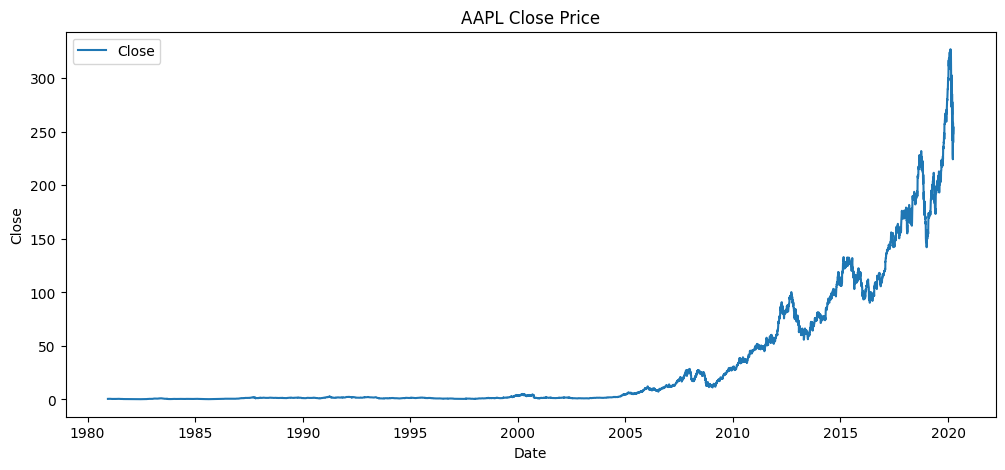

In [22]:
#Visualize closing price
plt.figure(figsize=(12,5))
plt.plot(aapl['Date'], aapl['Close'], label='Close')
plt.title('AAPL Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [23]:
#Prepare series for modeling (use Close)
data = aapl[['Date', 'Close']].copy()
close_values = data['Close'].values.reshape(-1, 1)

In [24]:
#Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_values)

# Save scaler for later use
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/close_scaler.save")

['models/close_scaler.save']

In [25]:
#Create sequences for supervised learning
def create_sequences(values, window):
    X, y = [], []
    for i in range(window, len(values)):
        X.append(values[i - window:i, 0])
        y.append(values[i, 0])
    return np.array(X), np.array(y)

window = 60  # lookback window
X_all, y_all = create_sequences(scaled_close, window)
# reshape for models: LSTM needs 3D, sklearn needs 2D
X_all_lstm = X_all.reshape(X_all.shape[0], X_all.shape[1], 1)

In [26]:
#Train/test split (80/20)
split_idx = int(0.8 * len(X_all))
X_train_lstm = X_all_lstm[:split_idx]
y_train = y_all[:split_idx]
X_test_lstm = X_all_lstm[split_idx:]
y_test = y_all[split_idx:]

In [27]:
#Try to import TensorFlow; if fails, use scikit-learn MLPRegressor
use_lstm = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    tf_version = tf.__version__
    print("TensorFlow available, version:", tf_version)
except Exception as e:
    print("TensorFlow import failed or not available. Falling back to scikit-learn MLPRegressor.")
    print("Import error:", e)
    use_lstm = False

# Function to inverse-scale predictions
def inv_scale(arr):
    arr = np.array(arr).reshape(-1, 1)
    return scaler.inverse_transform(arr).reshape(-1)

TensorFlow available, version: 2.18.0


In [28]:
#If using LSTM: build, train, predict
if use_lstm:
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(window, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train
    history = model.fit(
        X_train_lstm, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )

    # Save model
    model.save("models/lstm_aapl_model.h5")

    # Predict on test
    preds_scaled = model.predict(X_test_lstm)
    preds = inv_scale(preds_scaled)
    y_test_inv = inv_scale(y_test)

    mse = mean_squared_error(y_test_inv, preds)
    r2 = r2_score(y_test_inv, preds)
    print("LSTM Test MSE:", mse)
    print("LSTM Test R2:", r2)

#If not using LSTM: use MLPRegressor
else:
    from sklearn.neural_network import MLPRegressor
    # reshape data for scikit-learn: (samples, features)
    X_train = X_all[:split_idx]
    X_test = X_all[split_idx:]
    mlp = MLPRegressor(hidden_layer_sizes=(200,100), activation='relu', solver='adam',
                       max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)
    joblib.dump(mlp, "models/mlp_aapl_model.joblib")

    preds_scaled = mlp.predict(X_test).reshape(-1,1)
    preds = inv_scale(preds_scaled)
    y_test_inv = inv_scale(y_test)

    mse = mean_squared_error(y_test_inv, preds)
    r2 = r2_score(y_test_inv, preds)
    print("MLP Test MSE:", mse)
    print("MLP Test R2:", r2)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - loss: 2.6536e-05 - val_loss: 3.8407e-05
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 4.2178e-06 - val_loss: 2.2665e-04
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - loss: 4.2003e-06 - val_loss: 3.1190e-05
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - loss: 3.5577e-06 - val_loss: 3.0603e-05
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - loss: 4.5021e-06 - val_loss: 4.9649e-05
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 4.4454e-06 - val_loss: 8.2708e-05
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 3.8371e-06 - val_loss: 2.0051e-05
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - loss: 3.5772e-06 - val_loss: 1.8117e-05
Epoch 9/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 3.4940e-06 - val_loss: 2.7331e-05
Epoch 10/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 3.9371e-06 - val_loss: 7.7879e-05
Epoch 11/20
222/222 ━━━━━━━━━━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
LSTM Test MSE: 18.240065493939117
LSTM Test R2: 0.9945316059926685


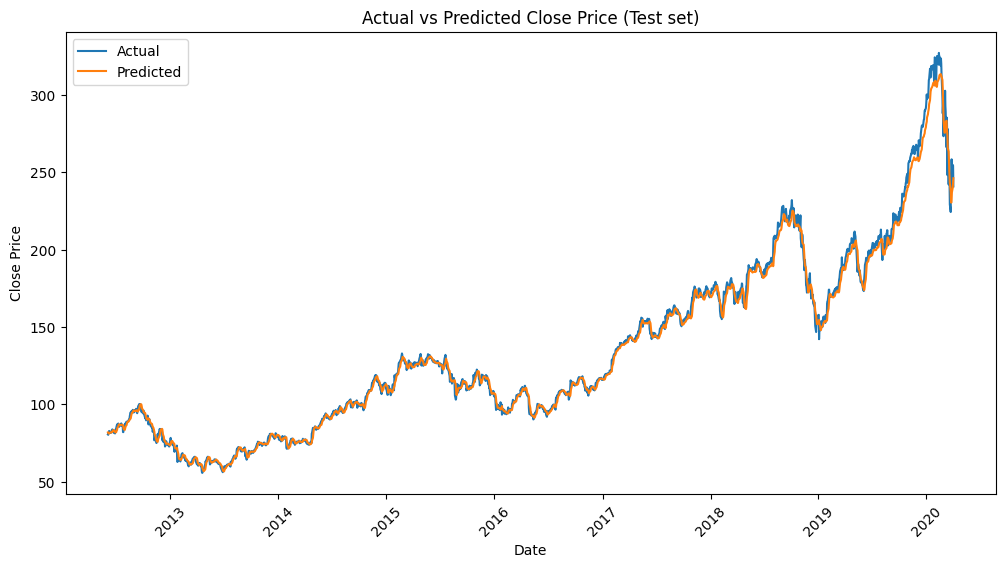

In [29]:
#Plot actual vs predicted on test set
# Determine corresponding dates for test set
test_start_index = window + split_idx
test_dates = data['Date'].values[test_start_index:test_start_index + len(preds)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, preds, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price (Test set)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [30]:
#Predict next-day closing price (single step)
# Use last `window` days from the full scaled_close
last_window = scaled_close[-window:].reshape(1, window, 1)
if use_lstm:
    next_scaled = model.predict(last_window)
    next_price = inv_scale(next_scaled)[0]
else:
    last_window_2d = scaled_close[-window:].reshape(1, window)
    next_scaled = mlp.predict(last_window_2d).reshape(-1,1)
    next_price = inv_scale(next_scaled)[0]

print("Next-day predicted close price (USD):", next_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Next-day predicted close price (USD): 245.25548


In [31]:
#Iterative forecast for next N days (e.g., 30 days)
def iterative_forecast(model_obj, start_scaled, n_days, use_lstm_flag):
    preds = []
    buffer = start_scaled.copy()  # shape (window, 1)
    for _ in range(n_days):
        if use_lstm_flag:
            x = buffer.reshape(1, window, 1)
            y_s = model_obj.predict(x)
        else:
            x = buffer.reshape(1, window)
            y_s = model_obj.predict(x).reshape(-1,1)
        preds.append(y_s[0,0])
        # append predicted value and drop oldest
        buffer = np.vstack([buffer[1:], [[y_s[0,0]]]])
    return np.array(preds)

n_forecast = 30
start_scaled = scaled_close[-window:].reshape(window, 1)
if use_lstm:
    future_scaled = iterative_forecast(model, start_scaled, n_forecast, True)
else:
    future_scaled = iterative_forecast(mlp, start_scaled, n_forecast, False)

future_prices = inv_scale(future_scaled)
print(f"Iterative {n_forecast}-day forecast (first 5 days): {future_prices[:5]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

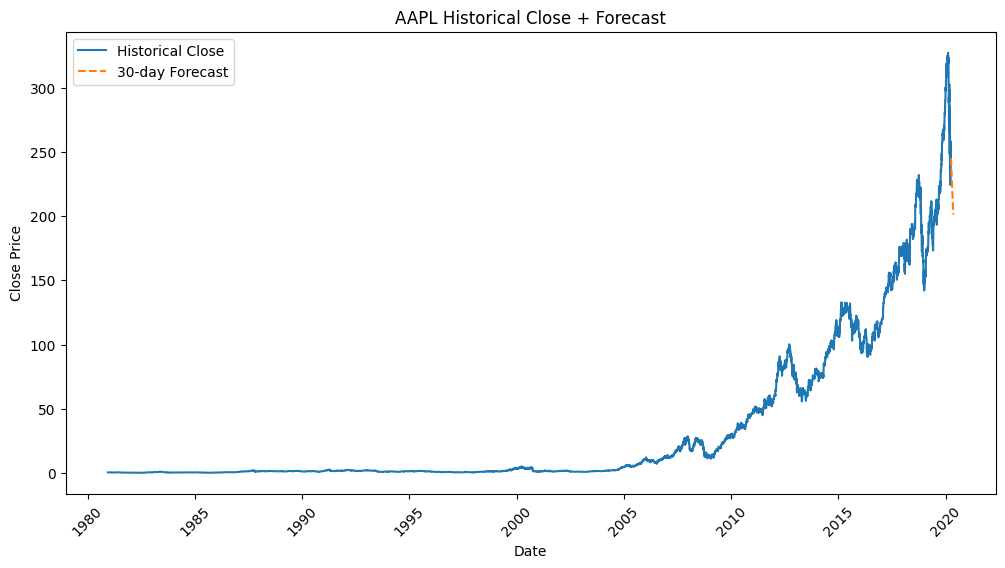

In [32]:
#Plot future forecast appended to historical close
last_dates = pd.to_datetime(data['Date'].values[-1])
future_dates = pd.date_range(start=last_dates + pd.Timedelta(days=1), periods=n_forecast, freq='B')  # business days
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Historical Close')
plt.plot(future_dates, future_prices, label=f'{n_forecast}-day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL Historical Close + Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [33]:
#Save artifacts summary
if use_lstm:
    print("Saved LSTM model: models/lstm_aapl_model.h5")
else:
    print("Saved MLP model: models/mlp_aapl_model.joblib")
print("Saved scaler: models/close_scaler.save")

Saved LSTM model: models/lstm_aapl_model.h5
Saved scaler: models/close_scaler.save


### Streamlit app







In [3]:
# streamlit run app.py